### [Optional] Reset the data folder

In [1]:
!rm -rf ./data/arrange/ ./data/model/

## Part 1: Fill in the Variable 
Please modify the variable to get the correct information.

In [2]:
# Label Data file
label_data_file = "project-6-at-2022-09-19-04-17-b9f72b54.json"

In [3]:
# Model learning rate
base_learning_rate = 0.01

In [4]:
# MLFlow experiment name
mlflow_experiment_name = "tutorial_screw_train"

## Part 2: Install python package

In [5]:
print("Skip this method. The environment is airgapped.")
print("You need to use the correct jupyter image.")

Skip this method. The environment is airgapped.
You need to use the correct jupyter image.


## Part 3: Data Processing

### Step 1: Prepare the Data
Download and extract the zip file, then follow the tutorial to use Label Studio to label the data.

In [6]:
# Kaggle dataset: https://www.kaggle.com/datasets/ruruamour/screw-dataset

original_data_folder_path = "./data/original/"
label_data_folder_path = "./data/label/"

### Step 2: Data ELT pipeline

We will do the data ELT pipeline in the following code.

#### Import the python package

In [7]:
import json
import shutil
import os
from pathlib import Path

#### Data Extraction: Read the label studio export json-format file

In [8]:
import pandas as pd

df = pd.read_json(os.path.join(label_data_folder_path, label_data_file))
df['image'] = df['image'].str.split(pat="/", expand=True)[8]
df.head()

,image,id,choice,annotator,annotation_id
0,ok001.png,40,good,demo@infuseai.io,44
1,ok002.png,39,good,demo@infuseai.io,43
2,ok003.png,38,good,demo@infuseai.io,42
3,ok004.png,37,good,demo@infuseai.io,41
4,ok005.png,36,good,demo@infuseai.io,40


#### Data Load-To: Create a training and validation data folder

In [9]:
arrange_data_folder_path = './data/arrange/'
dataset_type_list = ['train', 'valid']
label_list = ['good', 'bad']
dataset_dict = {}

for dataset_type in dataset_type_list:
    dataset_dict[dataset_type] = {}
    dataset_dict[dataset_type]['folder_path'] = os.path.join(arrange_data_folder_path, dataset_type)
    for label in label_list:
        arrange_subfolder_path = os.path.join(arrange_data_folder_path, dataset_type, label)
        dataset_dict[dataset_type][label] = {}
        dataset_dict[dataset_type][label]['folder_path'] = arrange_subfolder_path
        os.makedirs(arrange_subfolder_path, exist_ok=True)
    
dataset_dict

{'train': {'folder_path': './data/arrange/train',
  'good': {'folder_path': './data/arrange/train/good'},
  'bad': {'folder_path': './data/arrange/train/bad'}},
 'valid': {'folder_path': './data/arrange/valid',
  'good': {'folder_path': './data/arrange/valid/good'},
  'bad': {'folder_path': './data/arrange/valid/bad'}}}

#### Data Transformation: Put the original image data into arrangement folder.

In [10]:
val_count = 4
val_good_count = 0
val_bad_count = 0

arrange_folder_path_list = []
for original_file_name, label_result in zip(df['image'], df['choice']):
    original_file_path = os.path.join(original_data_folder_path, 'train', original_file_name)
    if label_result == 'good':
        if val_good_count < val_count:
            arrange_file_path = os.path.join(dataset_dict['valid']['good']['folder_path'], original_file_name)
            val_good_count = val_good_count + 1
        else:
            arrange_file_path = os.path.join(dataset_dict['train']['good']['folder_path'], original_file_name)
    else:
        if val_bad_count < val_count:
            arrange_file_path = os.path.join(dataset_dict['valid']['bad']['folder_path'], original_file_name)
            val_bad_count = val_bad_count + 1
        else:
            arrange_file_path = os.path.join(dataset_dict['train']['bad']['folder_path'], original_file_name)
    arrange_folder_path_list.append(arrange_file_path)
    shutil.copyfile(original_file_path, arrange_file_path)

df['arrange_path'] = arrange_folder_path_list
df.head()

,image,id,choice,annotator,annotation_id,arrange_path
0,ok001.png,40,good,demo@infuseai.io,44,./data/arrange/valid/good/ok001.png
1,ok002.png,39,good,demo@infuseai.io,43,./data/arrange/valid/good/ok002.png
2,ok003.png,38,good,demo@infuseai.io,42,./data/arrange/valid/good/ok003.png
3,ok004.png,37,good,demo@infuseai.io,41,./data/arrange/valid/good/ok004.png
4,ok005.png,36,good,demo@infuseai.io,40,./data/arrange/train/good/ok005.png


## Part 3: Model Training Pipeline

After labeled all the images, you can run the following cells to start training and log results to MLflow.

### Step 1: Import python package

In [11]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

2023-01-03 00:41:59.031147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-01-03 00:41:59.031203: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Step 2: mlflow initial

In [12]:
import mlflow
mlflow.set_experiment(mlflow_experiment_name)
mlflow.tensorflow.autolog()

2023/01/03 00:42:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


### Step 3: Setting dataset

In [13]:
BATCH_SIZE = 8
IMG_SIZE = (1024, 1024)

In [14]:
train_dataset = image_dataset_from_directory(dataset_dict['train']['folder_path'],
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

2023-01-03 00:42:02.471633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-01-03 00:42:02.471678: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 00:42:02.471703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-phadmin): /proc/driver/nvidia/version does not exist
2023-01-03 00:42:02.474453: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 32 files belonging to 2 classes.


In [15]:
validation_dataset = image_dataset_from_directory(dataset_dict['valid']['folder_path'],
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 8 files belonging to 2 classes.


#### Show example
Show some cases of training examples.

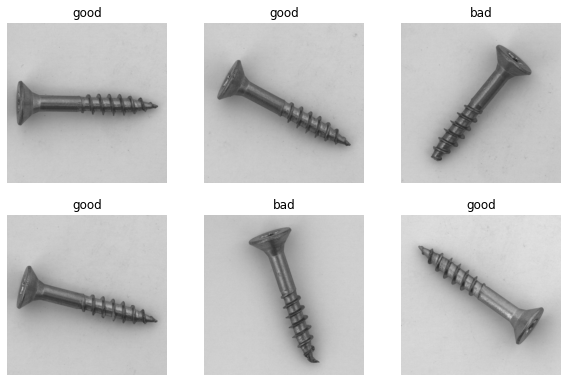

In [16]:
class_names = train_dataset.class_names

show_img = 1

if show_img:
    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(6):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

### Step 4: Build the Model
We use mobilenet as our model.

#### Build the data augmentation layer

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
])

#### Build the Input preprocessing application layer


In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### Build the mobilenet v3 base model


In [19]:
!mkdir ./data/model/
!tar -zxf ./data/imagenet_mobilenet_v3_large_100_224_feature_vector_5.tar.gz \
 --directory ./data/model/

In [20]:
model_url = "./data/model/"
base_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    hub.KerasLayer(model_url, trainable=False)
])
base_model.build([None, 224, 224, 3])

# Change base model trainable is False(We only fine-tune the model in this example.)
base_model.trainable = False

#### Build the prediction layer


In [21]:
prediction_layer = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.1))

#### Combine all the model layer into one model

In [22]:
inputs = tf.keras.Input(shape=(1024, 1024, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

In [23]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#### Get the model summary

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 1024, 1024, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 1024, 1024, 3)    0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 1024, 1024, 3)    0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 1280)              4226432   
                                                                 
 dense (Dense)               (None, 1)                 1281  

### Step 5: Model Training

#### Check the initial dataset metrics value

In [25]:
loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.8903 - accuracy: 0.5000


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.89
initial accuracy: 0.50


#### Setting the callback

In [27]:
def scheduler(epoch, lr):
    if epoch >= 10 and epoch % 10 == 0:
        return lr / 5
    return lr

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [28]:
callback_list = [learning_rate_scheduler]

#### Train the model

In [29]:
initial_epochs = 25

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=initial_epochs,
                    callbacks=callback_list)

2023/01/03 00:42:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'be60cbf132044a1e87359dc6eaef687e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/25
4/4 [==============================] - 12s 1s/step - loss: 0.6919 - accuracy: 0.6875 - val_loss: 2.0975 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - 5s 981ms/step - loss: 0.7779 - accuracy: 0.8125 - val_loss: 1.0295 - val_accuracy: 0.3750 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - 5s 1s/step - loss: 0.5321 - accuracy: 0.8750 - val_loss: 1.0592 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - 4s 1s/step - loss: 0.4299 - accuracy: 0.9062 - val_loss: 1.1955 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 5/25
4/4 [==============================] - 5s 1s/step - loss: 0.4310 - accuracy: 0.8750 - val_loss: 1.0194 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 6/25
4/4 [==============================] - 5s 1s/step - loss: 0.3644 - accuracy: 0.9375 - val_loss: 0.9425 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 7/25
4/4 [==============================] - 4s 980ms/step - loss: 0.3058 - accuracy: 0.968

2023-01-03 00:44:34.544357: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpjbxl262e/model/data/model/assets


### Step 6: Model Evaluation

In [30]:
lossfinal, accuracyfinal = model.evaluate(validation_dataset)

1/1 [==============================] - 1s 653ms/step - loss: 0.6646 - accuracy: 0.7500


In [31]:
print("final loss: {:.2f}".format(lossfinal))
print("final accuracy: {:.2f}".format(accuracyfinal))

final loss: 0.66
final accuracy: 0.75
